In [259]:
# Imports
import warnings
from tueplots import bundles
from tueplots.constants.color import rgb
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, RationalQuadratic, DotProduct, WhiteKernel, ConstantKernel as C

In [260]:
plt.rcParams.update(bundles.icml2022(column="full",nrows=1, ncols=2, usetex=False))

In [272]:
# Loading data
data=pd.read_csv('oktoberfest.csv')

# Translating the column names to English
data.rename(columns=
            {'jahr':'year','dauer':'duration [days]','besucher_gesamt':'total_visitors [million]',
                     'besucher_tag':'visitor_day [1000]','bier_preis':'beer_price [€]',
                     'bier_konsum':'beer_consumption [hectolitre]',
                     'hendl_preis':'chicken_price [€]','hendl_konsum':'chicken_consumption'},
            inplace=True)

In [273]:
data.tail(5)

,year,duration [days],total_visitors [million],visitor_day [1000],beer_price [€],beer_consumption [hectolitre],chicken_price [€],chicken_consumption
31,2016,17,5.6,329,10.57,66231,11.00,366876
32,2017,18,6.2,344,10.87,77836,11.41,466747
33,2018,16,6.3,394,11.30,78705,11.67,436492
34,2019,16,6.3,394,11.71,78502,12.15,434998
35,2022,17,5.7,335,13.45,71340,13.96,313636


We notice that there is no data available for the years : 2020, 2021. This is because the Oktoberfest had to be cancelled because of COVID-19


In [274]:
# Descriptive statistics
data.describe()

,year,duration [days],total_visitors [million],visitor_day [1000],beer_price [€],beer_consumption [hectolitre],chicken_price [€],chicken_consumption
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2002.555556,16.305556,6.297222,386.694444,7.053333,62476.611111,7.768889,564746.138889
std,10.635371,0.624246,0.398200,27.429723,2.770215,10196.196093,2.793060,129222.529768
min,1985.000000,16.000000,5.500000,329.000000,3.200000,48698.000000,3.920000,313636.000000
25%,1993.750000,16.000000,5.975000,369.000000,4.845000,53510.750000,5.317500,481139.250000
50%,2002.500000,16.000000,6.350000,394.000000,6.750000,61467.500000,8.130000,515646.000000
75%,2011.250000,16.000000,6.500000,406.000000,9.170000,71085.000000,9.890000,685465.750000
max,2022.000000,18.000000,7.100000,444.000000,13.450000,79225.000000,13.960000,807710.000000


The Oktoberfest which typically lasts for 16 days, on average attracts 6 million people every year.

The price of beer which was only 3.2 euros in 1985 rose to a whopping 13.45 euros by 2022.

We can observe a similar rise in price for the chicken from 3.9 euros in 1985 to 13.96 euros in 2022.

On an average, 6.25 million litres of beer is consumed every year which is equivalent to having a river of beer flowing continuously for a day, filling the equivalent of nearly three Olympic-sized swimming pools. 

# Plots

## Beer Price over the years

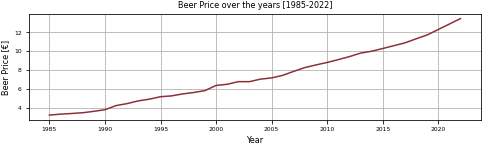

In [275]:
# How has the beer price changed over the years?

plt.plot(data['year'],data[['beer_price [€]']],color=rgb.tue_red)
plt.xlabel('Year')
plt.ylabel('Beer Price [€]')
plt.grid()
plt.title('Beer Price over the years [1985-2022]')
plt.show()

The price for 1 litre of beer increased almost linearly since 1985.

## Chicken prices over the years

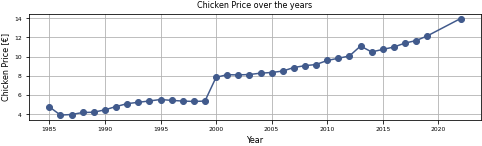

In [276]:
# How has the chicken price changed over the years?

plt.plot(data['year'],data[['chicken_price [€]']],color=rgb.tue_darkblue, marker='o')
plt.xlabel('Year')
plt.ylabel('Chicken Price [€]')
plt.title('Chicken Price over the years')
plt.grid(True)
#plt.tight_layout()

There was a huge price surge in the year 2000.

In the year 2013 there seems to be a price outlier as compared to the steady increase before.

# Model for Predicting Beer Price

Year: 2023

Duration (days): 18

Total visitors (in million): 7.2

Visitor day(in 1000): Total_visitors (in million)/Duration (days): 400

Beer price(per litre): 14.33

Beer consumption(per hectolitre): 65000

Chicken price(1/2 chicken): 16.49

Chicken Consumption: 488000


Additional visitor and consumption data for 2023 was retrieved from: 

https://www.muenchen.de/veranstaltungen/oktoberfest/aktuell/wiesn-2023-das-ist-die-abschlussbilanz

The beer price for 2023 was calculated as the average across the "Festhallen" from this table: 

https://stadt.muenchen.de/dam/jcr:2117b3fe-760c-4a9d-8123-38fe54bf49e4/ge-trraenke-wiesn23.pdf. This matches with the way data for previous years was recorded (From the Oktoberfest dataset description: "Die durchschnittlichen Bierpreise für 1 Maß Bier (1 Liter) in den Festzelten auf dem Oktoberfest (Preise in Euro)")

The chicken price for 2023 was calculated as an average across "Festhallen" retrieved from:

https://oktoberfest-guide.com/tents/menus-food-drinks/



## Exploring Linear Regression model

In [278]:
# Training data
X_beer = data.drop(columns=['beer_price [€]'])
y_beer = data['beer_price [€]']

In [279]:
# Your code that produces warnings

# Oktoberfest data for the year 2023
X_test = [[2023, 18, 7.2, 400, 65000, 16.49, 488000]]

# Create a polynomial regression model
degree = 1
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model 
polyreg.fit(X_beer, y_beer)

# Predict beer price for the test data
y_pred = polyreg.predict(X_test)
print(f'Predicted Beer Price for 2023: {y_pred[0]:.2f}')

Predicted Beer Price for 2023: 14.29


We observe that the beer price(per litre) predicted by the linear regression model for 2023 is close to the ground truth value.

Next, we aim to assess whether increasing the polynomial degree contributes to a more optimal fit.

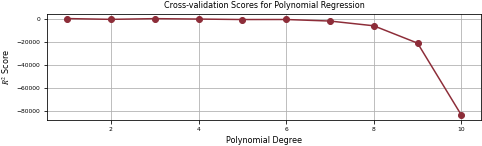

Best Polynomial Degree: 1


In [280]:
# To find the optimal number of degrees
degrees = np.arange(1, 11)

cv_scores = []

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_beer)

    model = LinearRegression()
    cv_score = np.mean(cross_val_score(model, X_poly, y_beer, cv=5, scoring='r2'))
    cv_scores.append(cv_score)

# Plot the cross-validation scores for each degree
plt.plot(degrees, cv_scores, marker='o',color=rgb.tue_red)
plt.title('Cross-validation Scores for Polynomial Regression')
plt.xlabel('Polynomial Degree')
plt.ylabel('$R^2$ Score')
plt.grid(True)
plt.show()

# Determine the degree with the highest cross-validation score
best_degree = degrees[np.argmax(cv_scores)]
print(f"Best Polynomial Degree: {best_degree}")

# Fit the final model with the best degree
poly_features = PolynomialFeatures(degree=best_degree)
X_poly = poly_features.fit_transform(X_beer)

final_model = LinearRegression()
final_model.fit(X_poly, y_beer)

# Plot the regression curve
x_range = np.linspace(X_beer.min().min(), X_beer.max().max(), 100).reshape(-1, 1)
x_range_poly = poly_features.transform(X_beer)
y_pred = final_model.predict(x_range_poly)


## Exploring Gaussian Process Regression model

In [281]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_beer, y_beer, test_size=0.2, random_state=42)

# List of kernels to explore
kernels_to_explore = [
    C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0), 
    C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0) ** 2,
    C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) * DotProduct(sigma_0=1.0),
    C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + DotProduct(sigma_0=1.0),

]

# Fit and evaluate models for each kernel
for kernel in kernels_to_explore:
    try:
        gpr_beer = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=0.1, normalize_y=True)
        # Fit the model
        gpr_beer.fit(X_train, y_train)

        # 2023 data
        X_test = np.array([[2023, 18, 7.2, 400, 65000, 16.49, 488000]])

        # Predict mean and standard deviation of the GP at test points
        beer_price_pred, beer_price_std = gpr_beer.predict(X_test, return_std=True)

        # Print the kernel type and predicted mean and standard deviation of beer price
        print(f'Kernel Type: {str(kernel)}')
        print(f'Predicted beer price for 2023: {beer_price_pred[0]} ± {beer_price_std[0]}\n')

    except Exception as e:
        print(f"Error with kernel {str(kernel)}: {e}")


Kernel Type: 1**2 * DotProduct(sigma_0=1)
Predicted beer price for 2023: 10.169626385377532 ± 1.014078011796072

Error with kernel 1**2 * DotProduct(sigma_0=1) ** 2: ("The kernel, 1**2 * DotProduct(sigma_0=1) ** 2, is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '14-th leading minor of the array is not positive definite')
Kernel Type: 1**2 * RBF(length_scale=1) * DotProduct(sigma_0=1)
Predicted beer price for 2023: 6.628571428571428 ± 40619.06797242386

Kernel Type: 1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1)
Predicted beer price for 2023: 13.136045867806612 ± 2.5221993917148153



Using Kernel Type: 1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1): 

The projected beer price for 2023 is estimated to be 13.13, with an uncertainty range of approximately ± 2.52.

In [282]:
plt.rcParams.update(bundles.icml2022(column="full",nrows=1, ncols=2, usetex=False))

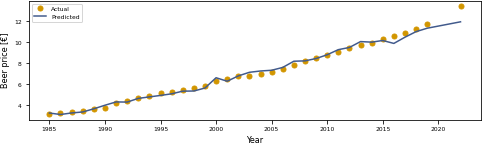

In [298]:
# Generate predictions for all years
beer_price_all_pred, _ = gpr_beer.predict(X_beer, return_std=True)

# Plotting beer price
#plt.figure(figsize=(20, 5))
plt.plot(data['year'], data['beer_price [€]'], 'r.', markersize=10, label='Actual',color=rgb.tue_orange)
plt.plot(data['year'], beer_price_all_pred, 'b-', label='Predicted',color=rgb.tue_darkblue)
plt.xlabel('Year')
plt.ylabel('Beer price [€]')
#plt.xticks(data['year'])
plt.legend()

#plt.title('Beer Price Prediction using Gaussian Process Regression')
plt.savefig('/home/tithi/Data_Literacy/Data-Literacy-Report/doc/fig/gaussian_beer_price_pred.pdf')
plt.show()


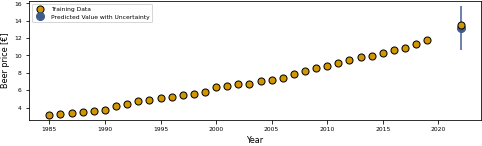

In [300]:
# Visualize model predictions for beer price
plt.scatter(data['year'], data['beer_price [€]'], s=50, zorder=10, edgecolors=(0, 0, 0), label='Training Data',color=rgb.tue_orange)
#plt.errorbar(X_test[0][0], beer_price_pred,color=rgb.tue_darkblue, yerr=beer_price_std, fmt='o', markersize=8, label='Predicted Value with Uncertainty')
plt.errorbar(X_test['year'].iloc[0], beer_price_pred,color=rgb.tue_darkblue, yerr=beer_price_std, fmt='o', markersize=8, label='Predicted Value with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Beer price [€]')
#plt.title('Gaussian Process Regression for Beer Price Prediction')
plt.legend(loc='upper left')
plt.savefig('/home/tithi/Data_Literacy/Data-Literacy-Report/doc/fig/gaussian_beer_price_CI.pdf')
plt.show()

Since the beer prices predominantly exhibit a linear relationship, for simplicity,  interpretability, and computational efficiency, the linear regression model would be a pragmatic choice.

# Model for Predicting Chicken Price

## Exploring Linear Regression model

In [286]:
# Oktoberfest data for the year 2023
X_chicken_test = [[2023, 18, 7.2, 400, 14.33, 65000, 488000]]
chicken_price= 16.49 

In [288]:
# Training data
X_chicken = data.drop(columns=['chicken_price [€]'])
y_chicken = data['chicken_price [€]']

In [289]:
# Create a polynomial regression model
degree = 1
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model 
polyreg.fit(X_chicken, y_chicken)

# Predict beer price for the test data
y_chicken_pred = polyreg.predict(X_chicken_test)
print(f'Predicted Chicken Price for 2023: {y_chicken_pred[0]:.2f}')

Predicted Chicken Price for 2023: 13.82


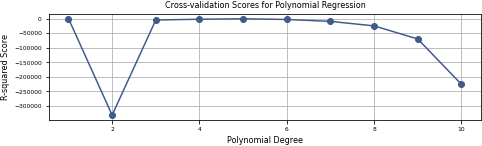

Best Polynomial Degree: 1


In [291]:
# To find the optimal number of degrees
degrees = np.arange(1, 11)

cv_scores = []

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_chicken)

    model = LinearRegression()
    cv_score = np.mean(cross_val_score(model, X_poly, y_chicken, cv=5, scoring='r2'))
    cv_scores.append(cv_score)

# Plot the cross-validation scores for each degree
plt.plot(degrees, cv_scores, marker='o',color=rgb.tue_darkblue)
plt.title('Cross-validation Scores for Polynomial Regression')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared Score')
plt.grid(True)
plt.show()

# Determine the degree with the highest cross-validation score
best_degree = degrees[np.argmax(cv_scores)]
print(f"Best Polynomial Degree: {best_degree}")

# Fit the final model with the best degree
poly_features = PolynomialFeatures(degree=best_degree)
X_poly = poly_features.fit_transform(X_chicken)

final_model = LinearRegression()
final_model.fit(X_poly, y_chicken)

# Plot the regression curve
x_range = np.linspace(X_chicken.min().min(), X_chicken.max().max(), 100).reshape(-1, 1)
x_range_poly = poly_features.transform(X_chicken)
y_chicken_pred = final_model.predict(x_range_poly)


We observe that the Linear Regression model produces a significantly different result from the ground truth value.

## Exploring Gaussian Process Regression

In [292]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chicken, y_chicken, test_size=0.2, random_state=42)

# List of kernels to explore
kernels_to_explore = [
    C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0), 
    C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0) ** 2,
    C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) * DotProduct(sigma_0=1.0),
    C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + DotProduct(sigma_0=1.0),

]

# Fit and evaluate models for each kernel
for kernel in kernels_to_explore:
    try:
        gpr_chicken = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=0.1, normalize_y=True)
        # Fit the model
        gpr_chicken.fit(X_train, y_train)

        # 2023 data
        X_chicken_test = [[2023, 18, 7.2, 400, 14.33, 65000, 488000]]

        # Predict mean and standard deviation of the GP at test points
        chicken_price_pred, chicken_price_std = gpr_chicken.predict(X_chicken_test, return_std=True)

        # Print the kernel type and predicted mean and standard deviation of beer price
        print(f'Kernel Type: {str(kernel)}')
        print(f'Predicted chicken price for 2023: {chicken_price_pred[0]} ± {chicken_price_std[0]}\n')

    except Exception as e:
        print(f"Error with kernel {str(kernel)}: {e}")


Kernel Type: 1**2 * DotProduct(sigma_0=1)
Predicted chicken price for 2023: 9.771033126586431 ± 0.8627417731542933

Error with kernel 1**2 * DotProduct(sigma_0=1) ** 2: ("The kernel, 1**2 * DotProduct(sigma_0=1) ** 2, is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '14-th leading minor of the array is not positive definite')
Kernel Type: 1**2 * RBF(length_scale=1) * DotProduct(sigma_0=1)
Predicted chicken price for 2023: 7.385714285714286 ± 41059.57254137133

Kernel Type: 1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1)
Predicted chicken price for 2023: 13.085777764755584 ± 1.959107798486052



Using Kernel Type: 1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1): 

The projected chicken price for 2023 is estimated to be 13.08, with an uncertainty range of approximately ± 1.96.

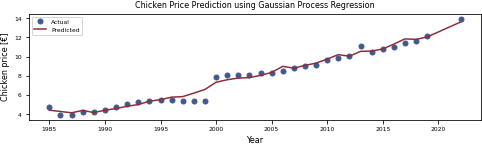

In [293]:
# Generate predictions for all years
chicken_price_all_pred, _ = gpr_chicken.predict(X_chicken, return_std=True)

# Plotting beer price
plt.plot(data['year'], data['chicken_price [€]'], 'r.', markersize=10, label='Actual',color=rgb.tue_darkblue)
plt.plot(data['year'], chicken_price_all_pred, 'b-', label='Predicted',color=rgb.tue_red)
plt.xlabel('Year')
plt.ylabel('Chicken price [€]')
plt.legend()
plt.title('Chicken Price Prediction using Gaussian Process Regression')
plt.show()

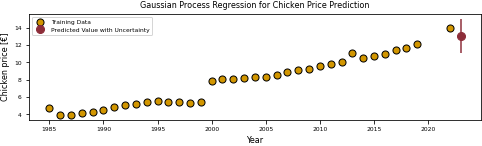

In [295]:
# Visualize model predictions for chicken price
plt.scatter(data['year'], data['chicken_price [€]'],color=rgb.tue_orange, s=50, zorder=10, edgecolors=(0, 0, 0), label='Training Data')
plt.errorbar(X_chicken_test[0][0], chicken_price_pred, yerr=chicken_price_std, fmt='o', color=rgb.tue_red, markersize=8, label='Predicted Value with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Chicken price [€]')
plt.title('Gaussian Process Regression for Chicken Price Prediction')
plt.legend()
plt.show()

In the context of the non-linear trend in chicken prices, the Gaussian Process Regression predicts a projected chicken price of 13.08 for the year 2023, with an associated uncertainty range of approximately ± 1.96. This estimate appears to be more plausible.

However, based on the outcomes derived from both models, it is evident that neither of them demonstrates satisfactory performance. This could be attributed to an anomalous spike in prices around the year 2000.